<a href="https://colab.research.google.com/github/dsankush/image_denoising/blob/main/image_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Before running this script please ensure that the required datasts are uploaded to google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import zipfile
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
import cv2
import os

from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras.utils import load_img, img_to_array 
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, LeakyReLU
from keras.layers import MaxPooling2D, Dropout, UpSampling2D
from keras import regularizers
import keras.backend as kb

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0) 

In [ ]:
import zipfile

# Will unzip the files so that you can see them..
files = ['train','test','train_cleaned']
for file in files:
    with zipfile.ZipFile("/content/drive/MyDrive/"+file+".zip",'r') as z:
        z.extractall(".")

In [ ]:
import glob 
target_width = 540
target_height = 420
def load_image(path):
    file_list = glob.glob(path+'/*.png')
    file_list.sort()
    img_list = np.empty((len(file_list), target_height, target_width, 1))
    for i, fig in enumerate(file_list):
        img = load_img(fig, color_mode='grayscale', target_size=(target_height, target_width))
        img_array = img_to_array(img).astype('float32')
        img_array = img_array / 255.0
        img_list[i] = img_array
    
    return img_list

def train_test_split(data,random_seed=55,split=0.75):
    set_rdm = np.random.RandomState(seed=random_seed)
    dsize = len(data)
    ind = set_rdm.choice(dsize,dsize,replace=False)
    train_ind = ind[:int(0.75*dsize)]
    val_ind = ind[int(0.75*dsize):]
    return data[train_ind],data[val_ind]

def augment_pipeline(pipeline, images, seed=5):
    ia.seed(seed)
    processed_images = images.copy()
    for step in pipeline:
        temp = np.array(step.augment_images(images))
        processed_images = np.append(processed_images, temp, axis=0)
    return(processed_images)
train_img = os.listdir('train')
train_cleaned_img = os.listdir('train_cleaned')
test_img = os.listdir('test')

In [ ]:
input_shape = (420, 540, 1)


In [ ]:
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (input_shape[1], input_shape[0]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, input_shape)
    
    return img

In [ ]:

train = []
train_cleaned = []
test = []

directory = 'train'
for f in sorted(os.listdir(directory)):
    train.append(process_image(os.path.join(directory, f)))
                               
directory = 'train_cleaned'                            
for f in sorted(os.listdir(directory)):
    train_cleaned.append(process_image(os.path.join(directory, f)))

directory = 'test'                               
for f in sorted(os.listdir(directory)):
    test.append(process_image(os.path.join(directory, f)))

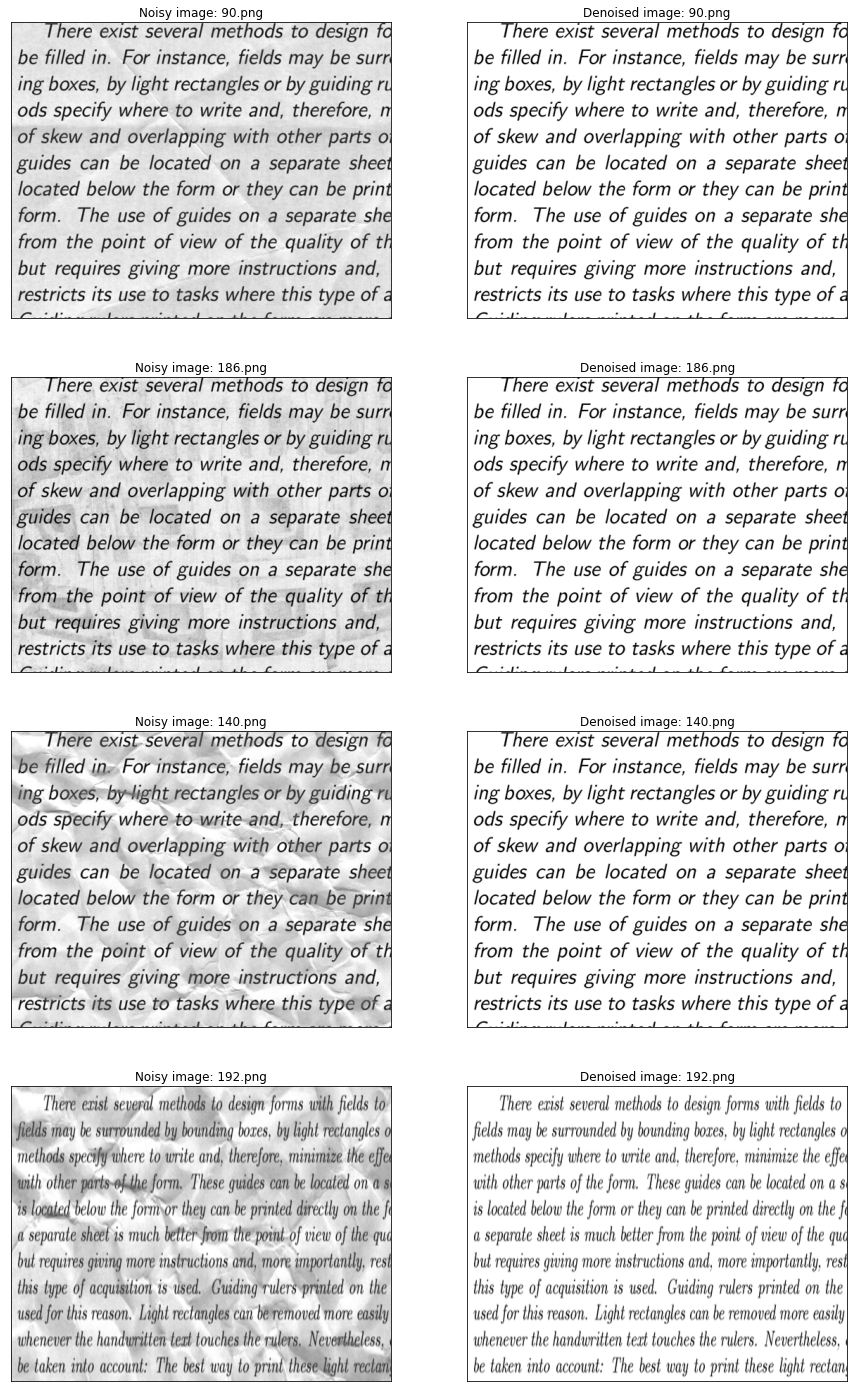

In [ ]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train = np.asarray(train)
y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [ ]:
batch_size = 32
kernel_size = 3
latent_dim = 16
layer_filters = [
    #{"filters":32, "kernel_size":3},
    {"filters":64, "kernel_size":3}, 
    {"filters":128, "kernel_size":3},
    {"filters":256, "kernel_size":3}
]

In [ ]:
from keras import backend as K
from keras.layers import Flatten, Dense, Reshape, Conv2DTranspose
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model

def model():
    input_layer = Input(shape=input_shape) 

    # encoding
    x = input_layer
    for layer_f in layer_filters:
        x = Conv2D(layer_f["filters"], (layer_f["kernel_size"], layer_f["kernel_size"]), 
                   activation='relu', padding='same')(x)
    
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Dropout(0.5)(x)

    # decoding
    for layer_f in layer_filters[::-1]:
        x = Conv2D(layer_f["filters"], (layer_f["kernel_size"], layer_f["kernel_size"]), 
                   activation='relu', padding='same')(x)
        
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    autoencoder = Model(inputs=[input_layer], outputs=[output_layer])
    autoencoder.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])
    return autoencoder

In [ ]:
model = model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 420, 540, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 420, 540, 128)     73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 420, 540, 256)     295168    
                                                                 
 batch_normalization (BatchN  (None, 420, 540, 256)    1024      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 210, 270, 256)    0         
 )                                                           

In [ ]:
model_weights_file_path = "Best_model_weights.hdf5"

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(filepath=model_weights_file_path, monitor="val_loss", verbose=1, save_best_only=True, mode="min", save_weights_only=True)
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=20)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, mode='min', min_delta=0.0001, cooldown=0, min_lr=0)

In [ ]:
callbacks=[checkpoint, es, lr_reduce]

epochs=3
batch_size=8

In [ ]:
history = model.fit(X_train, y_train, 
                    validation_data = (X_val, y_val), 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    verbose=1, 
                    callbacks=callbacks)
                   

Epoch 1/3
17/17 [==============================] - ETA: 0s - loss: 0.1277 - mae: 0.2587  
Epoch 1: val_loss improved from inf to 0.13652, saving model to Best_model_weights.hdf5
17/17 [==============================] - 2335s 137s/step - loss: 0.1277 - mae: 0.2587 - val_loss: 0.1365 - val_mae: 0.3572 - lr: 0.0010
Epoch 2/3
17/17 [==============================] - ETA: 0s - loss: 0.0469 - mae: 0.1529  
Epoch 2: val_loss improved from 0.13652 to 0.07850, saving model to Best_model_weights.hdf5
17/17 [==============================] - 2361s 139s/step - loss: 0.0469 - mae: 0.1529 - val_loss: 0.0785 - val_mae: 0.2347 - lr: 0.0010
Epoch 3/3
17/17 [==============================] - ETA: 0s - loss: 0.0293 - mae: 0.1156  
Epoch 3: val_loss improved from 0.07850 to 0.07629, saving model to Best_model_weights.hdf5
17/17 [==============================] - 2337s 137s/step - loss: 0.0293 - mae: 0.1156 - val_loss: 0.0763 - val_mae: 0.1750 - lr: 0.0010


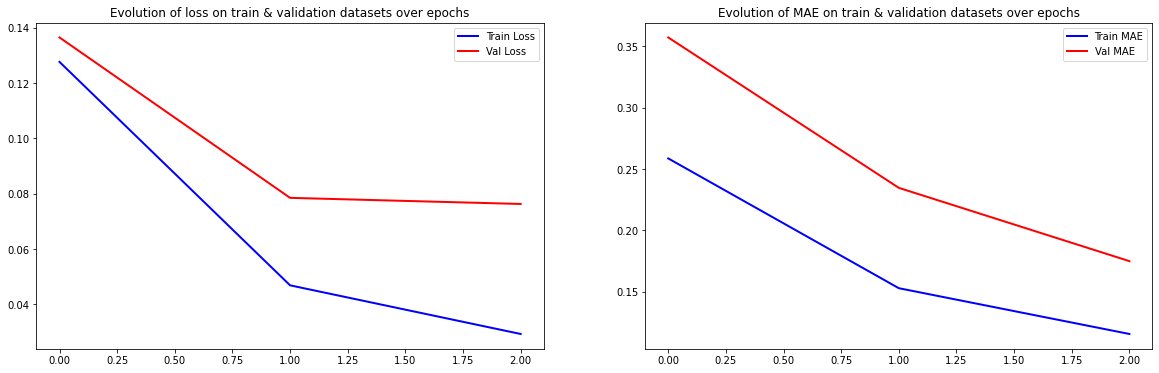

In [ ]:
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()


In [ ]:
model.load_weights(model_weights_file_path)

In [ ]:
y_test = model.predict(X_test, batch_size=batch_size)

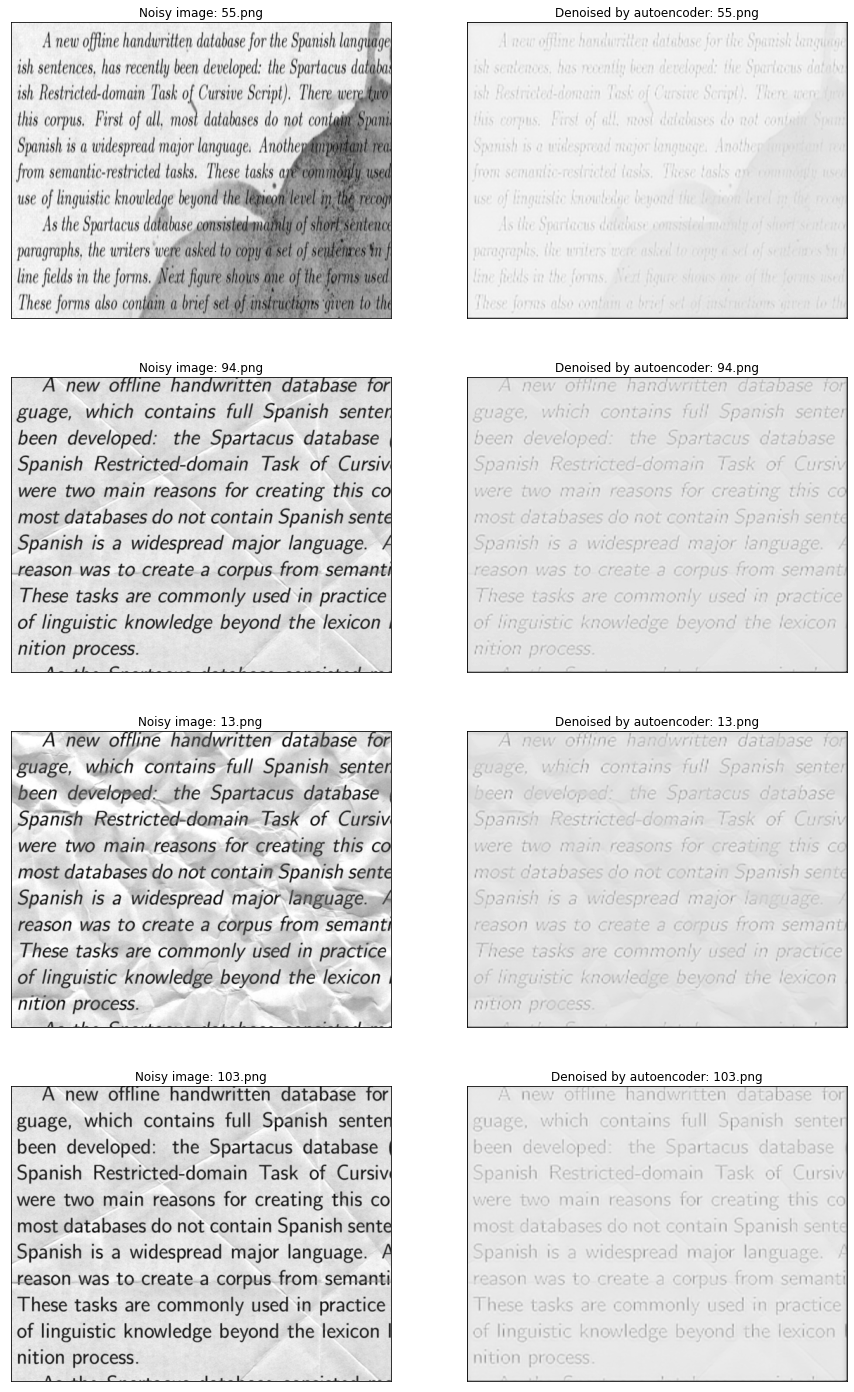

In [ ]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(y_test[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/AutoEncoderModel.h5')